# Activity 4. MNIST Hand-written digit classification

### **2019/11/21 CoE 202 Fall**<br/>

**Professor: Yong Hoon, Lee**</br>

**TA:Beomgu Kang, Seungjun moon**

In [1]:
from __future__ import print_function
from collections import namedtuple
from functools import partial

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.training import moving_averages

tf.logging.set_verbosity(tf.logging.ERROR)

## 1. Prepare the data
### <a href=http://yann.lecun.com/exdb/mnist/>MNIST dataset</a>
The MNIST has a training set of 55,000 examples, a validation set of 5,000 examples and a test set of 10,000 examples.

In [2]:
mnist = input_data.read_data_sets('./data/', one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


Load the training dataset

In [0]:
train_images = mnist.train.images[:1000]
train_labels = mnist.train.labels[:1000]
train_images = train_images.reshape([-1, 28, 28, 1])

Load the validation sets

In [0]:
val_images = mnist.validation.images
val_labels = mnist.validation.labels
val_images = val_images.reshape([-1, 28, 28, 1])

Plot the 1st hand-written digit and its one-hot label


One-hot labels for this image:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


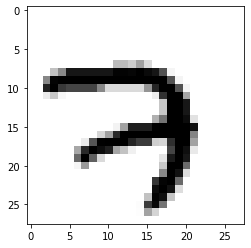

In [5]:
plt.imshow(train_images[0,:,:,0], cmap='Greys')
print("\nOne-hot labels for this image:")
print(train_labels[0])

## 2. Build a graph for VGGNet (Oxford, 2014)
Very Deep Convolutional Networks for Large-scale image recognition
https://arxiv.org/abs/1409.1556

<img src="img/fig2.png">

### Set hyperparameters
- ***log_dir*** : Directory name to save models
- ***n_epochs*** : Maximun training epoch
- ***n_outputs*** : The number of classes for labels
- ***init_lr*** : Learning rate for gradient descent
- ***l2_lambda*** : regularization parameter
- ***batch_size*** : The number of images to update paramerters once

In [0]:
log_dir = 'logs/'
n_epochs = 20
n_outputs = 10
init_lr = 0.01
batch_size = 100
l2_lambda = 0.0001

### Placeholder for learning rate, input images and labels

In [0]:
lrn_rate = tf.placeholder(tf.float32, shape=(), name='lrn_rate')
images = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='images')
labels = tf.placeholder(tf.int32, shape=(None), name='labels')

In [0]:
def vggnet(images, labels=None):
    vggnet_conv = partial(tf.layers.conv2d, kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda), padding="SAME")
    
    ''' 1st conv. '''
    x = vggnet_conv(images, filters=16, kernel_size=7, strides=[1,1])  # 7x7 filter, # of filters: 16, stride: 1
    x = tf.layers.batch_normalization(x, name='bn1')                   # batch normalization
    x = tf.nn.relu(x)                                                  # ReLU activation
    
    ''' 2nd conv.'''
    x = vggnet_conv(x, filters=16, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 16, stride 1
    x = tf.layers.batch_normalization(x, name='bn2')                   # batch normalization
    x = tf.nn.relu(x)                                                  # ReLU activation
    x = tf.layers.average_pooling2d(x, pool_size=[2,2], strides=[2,2]) # 2x2 average pooling, stride: 2
    
    ''' 3rd conv. '''
    x = vggnet_conv(x, filters=32, kernel_size=3, strides=[1, 1])      # 3x3 filter, # of filters: 32, stride: 1
    x = tf.layers.batch_normalization(x, name='bn3')                   # batch normalization
    x = tf.nn.relu(x)                                                  # ReLU activation
    
    ''' 4th conv. '''
    x = vggnet_conv(x, filters=32, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 32, stride 1
    x = tf.layers.batch_normalization(x, name='bn4')                   # batch normalization
    x = tf.nn.relu(x)                                                  # ReLU activation
    x = tf.layers.average_pooling2d(x, pool_size=[2,2], strides=[2,2]) # 2x2 average pooling stride 2
    
    ''' 5th conv. '''
    x = vggnet_conv(x, filters=64, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 64, stride: 1
    x = tf.layers.batch_normalization(x, name='bn5')                   # batch normalization
    x = tf.nn.relu(x)                                                  # ReLU activation
    
    ''' 6th conv. '''
    x = vggnet_conv(x, filters=64, kernel_size=3, strides=[1,1])       # 3x3 filter, # of filters: 64, stride: 1
    x = tf.layers.batch_normalization(x, name='bn6')                   # batch normalization
    x = tf.nn.relu(x)                                                  # ReLU activation
    
    img_feat = tf.reduce_mean(x, [1, 2])                               # Global average pooling
    return img_feat



## Assignment model

In [0]:
def assignment_net(images, labels=None):
    # Abbreviation for
    # Convolution > Batch Normalization > ReLU
    def conv_bn_relu(x, **kwargs):
        x = tf.layers.conv2d(
            x,
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda),
            padding="SAME",
            **kwargs
        )

        x = tf.layers.batch_normalization(x)
        x = tf.nn.relu(x)

        return x
    
    # (Conv > BN > ReLU) 1
    # 3x3 filter, # of filters: 16, stride: 1
    # output: (None, 28, 28, 16)
    x = conv_bn_relu(images, filters=16, kernel_size=3, strides=[1,1])

    # (Conv > BN > ReLU) 2
    # 3x3 filter, # of filters: 16, stride: 2
    # input: x (None, 28, 28, 16) / output: (None, 14, 14, 16)
    x1 = conv_bn_relu(x, filters=16, kernel_size=3, strides=[2, 2])
    
    # (Conv > BN > ReLU) 3 > Pool 
    # Conv: 3x3 filter, # of filters: 16, stride: 1
    # Pool: 2x2 pool, stride: 2
    # input: x (None, 28, 28, 16) / output: (None, 14, 14, 16)
    x2 = conv_bn_relu(x, filters=16, kernel_size=3, strides=[1, 1])
    x2 = tf.layers.average_pooling2d(x2, pool_size=[2, 2], strides=[2, 2])

    # Element-wise Sum (x1 + x2)
    # input: (None, 14, 14, 16) / output: (None, 14, 14, 16)
    x3 = tf.add(x1, x2)

    # (Conv > BN > ReLU) 4
    # 3x3 filter, # of filters: 16, stride: 1
    # input: (None, 14, 14, 16) / output: (None, 14, 14, 16)
    x5 = conv_bn_relu(x3, filters=16, kernel_size=3, strides=[1, 1])

    # Concatenate (x3, x5)
    # Axis: 3
    # input: (None, 14, 14, 16) * 2 / output: (None, 14, 14, 32)
    output = tf.concat((x3, x5), axis=3)

    # (Conv > BN > ReLU) 5
    # 3x3 filter, # of filters: 32, stride: 1
    # input: (None, 14, 14, 32) / output: (None, 14, 14, 32)
    output = conv_bn_relu(output, filters=32, kernel_size=3, strides=[1, 1])

    # Global Average Pool
    # Axis: 1, 2
    # input: (None, 14, 14, 32) / output: (None, 32)
    output = tf.reduce_mean(output, axis = [1, 2])
    
    return output

### Build a model

In [0]:
global_step = tf.Variable(0, trainable=False)

with tf.variable_scope('embed') as scope:
#     feats = simple_network(images)
    feats = assignment_net(images)

## Reshape
# feats = tf.reshape(feats, [batch_size, 32])
    
## Logits
logits = tf.layers.dense(feats, n_outputs, kernel_initializer=tf.uniform_unit_scaling_initializer(factor=2.0), 
                                               kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda))
## Evaluation
correct = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## SOFTMAX
preds = tf.nn.softmax(logits)

## Cost function
cent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cost_cls = tf.reduce_mean(cent, name='cent')

### L2 regularization

In [0]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cost = tf.add_n([cost_cls] + reg_losses)

### Momentum optimizer

In [0]:
lr  = tf.train.exponential_decay(init_lr, global_step, 1000, 0.8, staircase = True) # learning rate decay
optimizer = tf.train.MomentumOptimizer(lr, 0.9, use_nesterov=True)                  # Momentum optimizer
train_op = optimizer.minimize(cost)

# 3. Train a model

### Create a session and initialize parameters
Tensorflow operations must be executed in the session.

In [0]:
## MAKE SESSION
sess = tf.Session()

## INITIALIZE SESSION
sess.run(tf.global_variables_initializer())

### Updates parameters with back-propagation

In [14]:
# Validation Accuracies to draw a plot
plot_data = {
    'train': [],
    'val': []
}

for epoch in range(n_epochs+1):
    iteration_count = mnist.train.num_examples // batch_size
    plot_per_iteration = iteration_count // 5

    start_time = time.time()
    for iteration in range(iteration_count):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        X_batch = X_batch.reshape([-1, 28, 28, 1])
        (_, loss, loss_cls, prediction) = sess.run([train_op, cost, cost_cls, preds], 
                                                    feed_dict={images: X_batch, labels: y_batch})

        ## Getting validation accuracy 5 times per epoch
        if iteration % plot_per_iteration == 0:
            acc_train = accuracy.eval(session=sess, feed_dict={images: X_batch, labels: np.argmax(y_batch, axis=1)})
            plot_data['train'].append((epoch * iteration_count + iteration, acc_train))

            acc_val = accuracy.eval(session=sess, feed_dict={images: val_images, labels: np.argmax(val_labels, axis=1)})
            plot_data['val'].append((epoch * iteration_count + iteration, acc_val))
    
    duration = time.time() - start_time
    sec_per_epoch = float(duration)

    ## Accuracy every one epoch
    if epoch % 1 == 0:
        print(
            '  [*] TRAINING Iteration %d, Loss: %.4f, Acc: %.4f, Val Acc: %.4f (Took %.3fs)' % (
                    epoch, loss_cls,
                    plot_data['train'][-1][1], plot_data['val'][-1][1],
                    sec_per_epoch
            )
        )

print('Optimization done.')

  [*] TRAINING Iteration 0, Loss: 0.4653, Acc: 0.8100, Val Acc: 0.7378 (Took 10.197s)
  [*] TRAINING Iteration 1, Loss: 0.2434, Acc: 0.9300, Val Acc: 0.9444 (Took 7.892s)
  [*] TRAINING Iteration 2, Loss: 0.1185, Acc: 0.9700, Val Acc: 0.9600 (Took 7.852s)
  [*] TRAINING Iteration 3, Loss: 0.0477, Acc: 0.9700, Val Acc: 0.9708 (Took 7.895s)
  [*] TRAINING Iteration 4, Loss: 0.0657, Acc: 0.9700, Val Acc: 0.9712 (Took 7.864s)
  [*] TRAINING Iteration 5, Loss: 0.0478, Acc: 0.9700, Val Acc: 0.9778 (Took 7.853s)
  [*] TRAINING Iteration 6, Loss: 0.1469, Acc: 1.0000, Val Acc: 0.9758 (Took 7.869s)
  [*] TRAINING Iteration 7, Loss: 0.0287, Acc: 1.0000, Val Acc: 0.9798 (Took 7.865s)
  [*] TRAINING Iteration 8, Loss: 0.0899, Acc: 1.0000, Val Acc: 0.9786 (Took 7.878s)
  [*] TRAINING Iteration 9, Loss: 0.0688, Acc: 0.9800, Val Acc: 0.9830 (Took 7.870s)
  [*] TRAINING Iteration 10, Loss: 0.1168, Acc: 0.9900, Val Acc: 0.9790 (Took 7.838s)
  [*] TRAINING Iteration 11, Loss: 0.0569, Acc: 1.0000, Val Acc

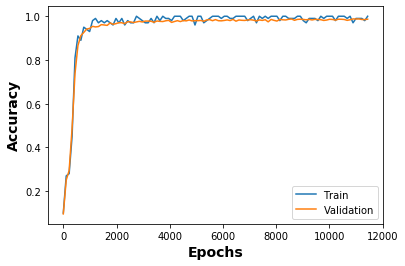

In [15]:
# Plotting

plt.plot(*zip(*plot_data['train']))
plt.plot(*zip(*plot_data['val']))
plt.xlabel("Epochs", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# 4. Test a model

### Load the test images and labels


One-hot labels for this image:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


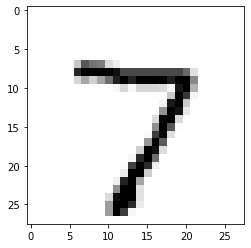

In [16]:
## READ MNIST INPUTS
test_images = mnist.test.images
test_labels = mnist.test.labels
test_images = test_images.reshape([-1, 28, 28, 1])

## Plot the 1st test image and label
plt.imshow(test_images[0,:,:,0], cmap='Greys')
print("\nOne-hot labels for this image:")
print(test_labels[0])

### Check the prediction for the first image

In [17]:
prediction = sess.run(preds, feed_dict={images: test_images[0,:,:,0].reshape(1,28,28,1), labels: test_labels[0]})

print("The prediction of the network is: %d" % np.argmax(prediction))

The prediction of the network is: 7


### Average the accuray for test set

In [19]:
test_acc = accuracy.eval(session=sess, feed_dict={images: test_images, labels: np.argmax(test_labels, axis=1)})
print('Acc: %.4f' % test_acc)

Acc: 0.9852


## Assignment<hr>
### 1. A simple network for MNIST
Design the following CNN and apply the CNN to the MNIST dataset.</br>

<img src="img/fig3.png">

***Hint)*** 
- Elementwise-sum: tf.add() <br/>
- Concatenate: tf.concat()


### Submission (Due: Nov. 28 Thu.)
Compare the results with that of VGGNET and submit your report by Thursday, November 28 to **"almona@kaist.ac.kr"**